# Prerequisite


## Download nltk
This work makes havy use of the nltk-framework, the download can be startet with: '#nltk.download()'

In [ ]:
import nltk

nltk.download()

## Checking for GPU

*If you dont have a GPU in your maschine you can ignore these section*

For better performece we recomend using your GPU, if none is detectet consider adding it to your python-enviroment.

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

print("There is", len(gpus), "detected GPU")
print("There is", len(cpus), "detected CPU")

In addition we recommond enlable memory growth and restrict the amount of GPU-Memory used

In [ ]:
# https://medium.com/@starriet87/tensorflow-2-0-wanna-limit-gpu-memory-10ad474e2528
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    #tf_vdc = [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7168)]
    #tf.config.experimental.set_virtual_device_configuration(gpus[0], tf_vdc)
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

# Loading the Data
We load the required data into to a pandas dataframes and join them by a common field.

for convinient use we transform all identifyers to lower case

In [ ]:
import pandas as pd

song_df = pd.read_csv('./song-lyrics/lyrics-data.csv')
author_df = pd.read_csv('./song-lyrics/artists-data.csv')

song_df = song_df.rename(columns={'ALink': 'Link'})

raw_df = song_df.merge(author_df, on='Link') 
raw_df.columns = raw_df.columns.str.lower()

print("There are", len(raw_df), "datasets loaded")

# Remove unneedet data

we removed all samples which arnt english or are duplicates

In [ ]:
import pandas as pd

columns_to_drop = ['sname','slink','link', 'popularity', 'genres', 'songs', 'link', 'idiom']

filterd_df = raw_df[raw_df.idiom.eq('ENGLISH')]
filterd_df = filterd_df.drop_duplicates(subset='slink', keep='first') 
filterd_df = filterd_df.drop(columns_to_drop, axis=1)

# General preprocessing

for further procssesing the lyrics get tokenized, lemmatized and cleand

In [ ]:
import pandas as pd

transformed_df = filterd_df

## Lowercase

In [ ]:
import pandas as pd

transformed_df['lyric'] = transformed_df['lyric'].str.lower()

## Tokenize

In [ ]:
import nltk

def lyric_to_verse(lyric):
    return nltk.sent_tokenize(lyric,language='english')

def verse_to_word(verse):
    return nltk.word_tokenize(verse, language='english')

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lyric_to_verse(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: [verse_to_word(verse) for verse in x]) 

## Lemmatiz

now we lemmatize our tokens, this may take a wile

In [ ]:
import nltk
from nltk.corpus import wordnet


#by http://textmining.wp.hs-hannover.de/Preprocessing.html
def pos_tagger(sentences):
    return [nltk.pos_tag(sent) for sent in sentences]

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wordnet.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wordnet.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wordnet.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wordnet.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)
    
def lem(sentences):
    transformed = []
    for sentence in sentences:
        transformed.append([lemmatize(lemmatizer,word,wntag(pos)) for (word,pos) in sentence])
    return transformed 

lemmatizer = nltk.WordNetLemmatizer()

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: pos_tagger(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: lem(x)) 

## Cleanup

we remove any artefacts which surviced lematisation like empty words, single letter words and all non alphabetic characters 

In [ ]:
import re

def clean_non_alphabetic_characters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(map(lambda x: re.sub("[\W_]", '', x), sentence)))
    return cleaned

def clean_empty_words(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: x != '' and x != "", sentence)))
    return cleaned

def clean_single_letters(sentences):
    cleaned = []
    for sentence in sentences:
        cleaned.append(list(filter(lambda x: len(x) != 1, sentence)))
    return cleaned

def clean_empty_sentences(sentences):
    return list(filter(lambda x : len(x) != 0, sentences))

transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_non_alphabetic_characters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_words(x))  
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_single_letters(x)) 
transformed_df['lyric'] = transformed_df['lyric'].transform(lambda x: clean_empty_sentences(x)) 

# Optional preprocessing


## Remove to long Lyrics

checken ob lieder die länger wie 1000 oder 1500 wirklich save sind, am besten erstmal händisch nachschauen

In [ ]:
#todo

## Remove additional Genres

alle generes rauswerfen die für weniger als x lieder haben 

In [ ]:
#todo

## Normalize dataset

schau das du von allen genres gleich viele lieder hast 

# Store preproccesd data

## Save to disk

In [ ]:
transformed_df.to_csv (r'./export_dataframe.csv', index = False, header=True)

## Load form disk

In [ ]:
import pandas as pd

transformed_df = pd.read_csv(r'./export_dataframe.csv', converters={'lyric': eval})

## Helper

kleiner helfer um firsche dfs zu bekommen falls man destruktiv daten bearbeitet

In [3]:
from helper import flatten
import pandas as pd
import pickle

restored_df = pd.read_csv(r'./export_dataframe.csv', converters={'lyric': eval})

def get_fresh_copy(frac=1):
    copy_df = pickle.loads(pickle.dumps(restored_df.sample(frac=frac, random_state=1)))
    return copy_df

def get_fresh_flatted_copy(frac=1):
    copy_df = get_fresh_copy(frac)
    copy_df['lyric'] = copy_df['lyric'].transform(lambda x: flatten(x))
    return copy_df
    

# Look at the data

## GenreDistribution

first we will look at the distribution of generes in our dataset

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
sns.countplot(data=get_fresh_copy(), x='genre')

## FreqencyDistribution

freqency distribution of the most common words in our dataset

to see if removing stopwords is a good idea we have a look ate the destribuition of stopwords over the difertent genres

In [ ]:
#todo nachschauen wieviele wörter wie oft auftauchen

In [ ]:
#todo refactor 

import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
        
flatted_df = get_fresh_flatted_copy(1)
genres = flatted_df.genre.unique()

df_container = {}
fd_container = {}

total_word_count = {}

merged_fd_df = pd.DataFrame(data = nltk.FreqDist(itertools.chain.from_iterable(flatted_df['lyric'])).items(), columns=['words', 'frequency'])
merged_fd_df = merged_fd_df.sort_values("frequency", ascending=False)

#in viele kleine loops zerhacken und erklären was passiert
#und vielleicht noch den duchschnitt hinzufügen, allso nicht nach genre gefilterd
for genre in genres:
    df_container[genre] = flatted_df[flatted_df.genre.eq(genre)]
    fd_container[genre] = nltk.FreqDist(itertools.chain.from_iterable(df_container[genre]['lyric']))
    total_word_count[genre] = sum(fd_container[genre].values())
    fd_container[genre] = pd.DataFrame(fd_container[genre].items(), columns=['words', genre])
    fd_container[genre][genre] = fd_container[genre][genre].transform(lambda x: x/total_word_count[genre]) 
    merged_fd_df = merged_fd_df.merge(fd_container[genre], on='words')

    
merged_fd_df = merged_fd_df.drop(['frequency'], axis=1)
merged_fd_df = merged_fd_df.set_index('words')

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)    
sns.lineplot(data=merged_fd_df.head(50))

## Lyricslength Distribution by genre(word)

we look if some generes as more likly to have shorter or longer lyrics

In [ ]:
def freqenzyDistribution(data, level='lyric'):
    data[level] = data[level].transform(lambda x: len(x))

    genres = data.genre.unique()

    df_container = {}
    mean_container = {}
    std_container = {}
    counts_container = {}

    for genre in genres:
        df_container[genre] = pickle.loads(pickle.dumps(data[data.genre.eq(genre)]))

    for genre in genres:
        mean_container[genre] = df_container[genre][level].values.mean()

    for genre in genres:
        std_container[genre] = df_container[genre][level].values.std()

    for genre in genres:
        counts_container[genre] = df_container[genre][level].value_counts(normalize=True)

    for genre in genres:
        counts_container[genre] = pd.DataFrame.from_dict(counts_container[genre])
        counts_container[genre]['genre'] = genre
        counts_container[genre] = counts_container[genre].reset_index()
        counts_container[genre] = counts_container[genre].rename(columns={level: 'count'})
        counts_container[genre] = counts_container[genre].rename(columns={'index': 'length'})

    return pd.concat(counts_container.values())

In [ ]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
    
        
flatted_df = get_fresh_flatted_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.scatterplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

## Lyricslength Distribution by genre(vers)

we look if some generes as more likly to have shorter or longer lyrics

In [ ]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from helper import melt

flatted_df = get_fresh_copy(1)
flatted_df = pd.DataFrame(melt(flatted_df))

result_df = freqenzyDistribution(flatted_df, 'verse')

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

## Lyricslength Distribution by genre(lyric)

we look if some generes as more likly to have shorter or longer lyrics

In [ ]:
import itertools
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import pandas as pd

flatted_df = get_fresh_copy(1)
result_df = freqenzyDistribution(flatted_df)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=result_df[result_df['count']>= 0.001], x="length", y="count", hue="genre")

# Learning

## Simple multible dense-layers

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

preprocessed_df = get_fresh_flatted_copy(0.1)

x_train, x_test, y_train, y_test = train_test_split(preprocessed_df['lyric'], preprocessed_df['genre'], test_size=0.4)
tokenizer = Tokenizer(num_words=10000)

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(y_train)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

num_classes =  len(preprocessed_df['genre'].unique())
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')


display(x_train)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

display(y_test)


model = Sequential()
model.add(Dense(16, input_shape=(10000, ), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

batch_size = 32
epochs = 150

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.2)
score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)

## Convolution with dropout
https://keras.io/api/layers/core_layers/dense/

In [10]:
MAX_SEQUENCE_LENGTH = 400
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

### Prepare Data

In [11]:
import numpy as np
from helper import loadGloveModel

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


#https://stackoverflow.com/questions/42320834/sklearn-changing-string-class-label-to-int
preprocessed_df = get_fresh_flatted_copy(1)
preprocessed_df.genre = pd.factorize(preprocessed_df.genre)[0]

labels_index = preprocessed_df['genre'].unique()
display(np.asarray(labels_index))

texts = np.asarray(preprocessed_df['lyric'])
labels = np.asarray(preprocessed_df['genre'])
                
print('Found %s texts.' % len(texts))
print('Found %s labels.' % len(labels_index))

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


array([0, 1, 2, 3, 4, 5])

Found 87151 texts.
Found 6 labels.
Found 127415 unique tokens.
Shape of data tensor: (87151, 400)
Shape of label tensor: (87151, 6)


### Split Data
split the data into a training set and a validation set

In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

### Build embedding layer

#### pre-trained embedding

In [13]:
embeddings_index = loadGloveModel()
print('Found %s word vectors.' % len(embeddings_index))

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

#load pre-trained word embeddings into an Embedding layer
#note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

Found 400000 word vectors.


#### not pre-trained embedding

In [14]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH)

### Train

In [15]:
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          validation_data=(x_val, y_val))

Epoch 1/20
545/545 [==============================] - 33s 61ms/step - loss: 0.9957 - acc: 0.5864 - val_loss: 0.7301 - val_acc: 0.6937
Epoch 2/20
545/545 [==============================] - 34s 63ms/step - loss: 0.7304 - acc: 0.6930 - val_loss: 0.6616 - val_acc: 0.7319
Epoch 3/20
545/545 [==============================] - 35s 64ms/step - loss: 0.6727 - acc: 0.7233 - val_loss: 0.6525 - val_acc: 0.7334
Epoch 4/20
545/545 [==============================] - 36s 65ms/step - loss: 0.6350 - acc: 0.7414 - val_loss: 0.6266 - val_acc: 0.7425
Epoch 5/20
545/545 [==============================] - 35s 65ms/step - loss: 0.6045 - acc: 0.7588 - val_loss: 0.6982 - val_acc: 0.7293
Epoch 6/20
545/545 [==============================] - 35s 64ms/step - loss: 0.5650 - acc: 0.7767 - val_loss: 0.8020 - val_acc: 0.7435
Epoch 7/20
545/545 [==============================] - 36s 66ms/step - loss: 0.5399 - acc: 0.7906 - val_loss: 0.9361 - val_acc: 0.7265
Epoch 8/20
545/545 [==============================] - 36s 67ms

<AxesSubplot:>

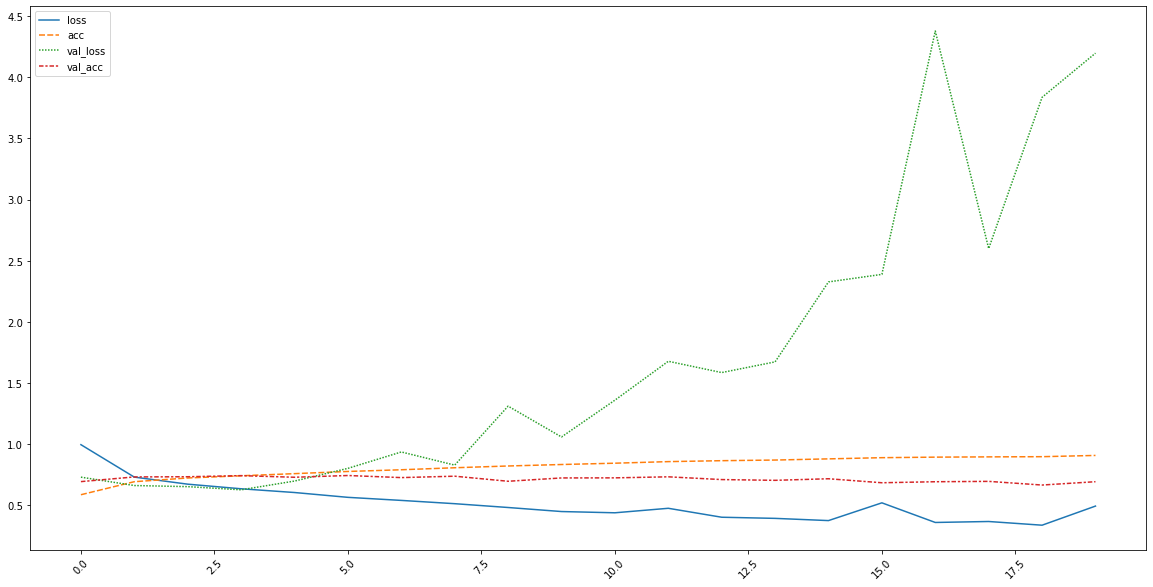

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
sns.lineplot(data=history_df)